In [1]:
# !pip install biopandas
# !pip install seaborn

Based on https://www.kaggle.com/code/hengck23/lb0-335-deepdgg-server-benchmark and https://www.kaggle.com/code/lucasmorin/nesp-changes-eda-and-baseline  
Additionaly: https://curie.utmb.edu/cgi-bin/xgetarea.cgi

In [2]:
import Levenshtein
import pandas as pd
from biopandas.pdb import PandasPdb
import numpy as np
from Bio.SubsMat import MatrixInfo
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load data

In [3]:
cap_sub_score_zero = False
ddg_filna_score = -0.25
demask_filna_score = -0.4
submit_col = 'rank_pow'
sigmoid_norm_factor = 3

In [4]:
class paths:
    TRAIN = "./data/train.csv"
    TEST = "./data/test.csv"
    SUBMISSION = "./data/sample_submission.csv"
    PDB_FILE = "./data/wildtype_structure_prediction_af2.pdb"

In [5]:
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'

In [6]:
# source: https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/354783
def get_mutation_info(_row, _wildtype=base):
    terminology_map = {"replace":"substitution", "insert":"insertion", "delete":"deletion"}
    req_edits = Levenshtein.editops(_wildtype, _row["protein_sequence"])
    _row["n_edits"] = len(req_edits)

    if _row["n_edits"]==0:
        _row["edit_type"] = _row["edit_idx"] = _row["old_aa"] = _row["new_aa"] = pd.NA
    else:
        _row["edit_type"] = terminology_map[req_edits[0][0]]
        _row["edit_idx"] = req_edits[0][1]
        _row["old_aa"] = _wildtype[_row["edit_idx"]]
        _row["new_aa"] = _row["protein_sequence"][req_edits[0][2]] if _row["edit_type"]!="deletion" else pd.NA
    return _row

def revert_to_wildtype(protein_sequence, edit_type, edit_idx, old_aa, new_aa):
    if pd.isna(edit_type):
        return protein_sequence
    elif edit_type!="insertion":
        new_wildtype_base = protein_sequence[:edit_idx]
        if edit_type=="deletion":
            new_wildtype=new_wildtype_base+old_aa+protein_sequence[edit_idx:]
        else:
            new_wildtype=new_wildtype_base+old_aa+protein_sequence[edit_idx+1:]
    else:
        new_wildtype=protein_sequence[:edit_idx]+old_aa+protein_sequence[edit_idx:]
    return new_wildtype

#helper function
def read_list_from_file(list_file):
    with open(list_file) as f:
        lines  = f.readlines()
    return lines


## Raw data

b_factor from PDB structure is useful

In [7]:
test_df = pd.read_csv(paths.TEST)
test_df = test_df.apply(get_mutation_info, axis=1)
test_df.loc[test_df.edit_type.isna(), 'edit_type'] = 'nothing'
test_df.head()

,seq_id,protein_sequence,pH,data_source,n_edits,edit_type,edit_idx,old_aa,new_aa
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,E
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,K
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,1,deletion,16,L,<NA>
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,C
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,F


## pLDDT

In [8]:
pdb_df =  PandasPdb().read_pdb(paths.PDB_FILE)
pdb_df.df.keys()

dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])

In [9]:
atom_df = pdb_df.df['ATOM']
atom_df['residue_number_0based'] = atom_df['residue_number'] - 1
map_number_to_b = atom_df.groupby('residue_number_0based').b_factor.mean()
test_df['b_factor'] = test_df.edit_idx.map(map_number_to_b).fillna(0)
test_df.loc[test_df['edit_type']=='deletion', 'new_aa'] = '-'
test_df.loc[test_df['edit_type']=='insertion', 'new_aa'] = '+'
test_df.loc[:,'mut_string'] =  test_df.old_aa+test_df.edit_idx.astype(str)+test_df.new_aa
test_df.head()

,seq_id,protein_sequence,pH,data_source,n_edits,edit_type,edit_idx,old_aa,new_aa,b_factor,mut_string
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,E,55.23,L16E
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,K,55.23,L16K
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,1,deletion,16,L,-,55.23,L16-
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,C,69.25,K17C
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,F,69.25,K17F


## DeepDDG

In [10]:
ddg = read_list_from_file('./data/deepddg/wildtype_structure_prediction_af2.deepddg.ddg.txt')

header = ddg[0]
data = [s.split() for s in ddg[1:]]

df = pd.DataFrame(data, columns = ['chain', 'WT', 'ResID', 'Mut', 'ddG'])
df.ddG = df.ddG.astype(np.float32)
df.ResID = df.ResID.astype(int)  
df.loc[:,'location'] = df.ResID -1  #change to 0-indexing
df.loc[:,'mut_string'] = df.WT+df.location.astype(str)+df.Mut
df.head()

,chain,WT,ResID,Mut,ddG,location,mut_string
0,A,V,1,A,-0.119,0,V0A
1,A,V,1,R,-0.132,0,V0R
2,A,V,1,N,-0.155,0,V0N
3,A,V,1,D,-0.158,0,V0D
4,A,V,1,C,-0.162,0,V0C


In [11]:
test_df = test_df.merge(df[['ddG','mut_string']], on='mut_string', how='left')
test_df.loc[test_df['ddG'].isna(), 'ddG'] = ddg_filna_score
test_df.head()

,seq_id,protein_sequence,pH,data_source,n_edits,edit_type,edit_idx,old_aa,new_aa,b_factor,mut_string,ddG
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,E,55.23,L16E,-0.226
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,K,55.23,L16K,-0.169
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,1,deletion,16,L,-,55.23,L16-,-0.250
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,C,69.25,K17C,-1.277
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,F,69.25,K17F,-1.353


## Blosum 100 matrix
$score_{adj}$ is calculated from Blosum 100 substitution matrix by $1 - \frac{1}{1+e^{-x/c}}$, where $c$ is a constant 3.

In [12]:
sub_scores = []
sub_mat = MatrixInfo.blosum100
for i in range(len(test_df)):
    mut_type = test_df.edit_type.values[i]
    if mut_type == 'substitution':
        try:
            sub_score = sub_mat[(test_df.old_aa.values[i], test_df.new_aa.values[i])]
        except KeyError:
            sub_score = sub_mat[(test_df.new_aa.values[i], test_df.old_aa.values[i])]
    elif mut_type == 'nothing':
        sub_score = 0
    else:
        sub_score = -10
    sub_scores.append(sub_score)

In [13]:
test_df['sub_score'] = sub_scores
if cap_sub_score_zero:
    test_df.loc[test_df['sub_score'] > 0, 'sub_score'] = 0
test_df['score_adj'] = [ 1 - (1 / (1+np.exp(-x/sigmoid_norm_factor))) for x in sub_scores]
test_df['b_factor_adj'] = test_df['b_factor'] * test_df['score_adj'] 
test_df.head(5)

,seq_id,protein_sequence,pH,data_source,n_edits,edit_type,edit_idx,old_aa,new_aa,b_factor,mut_string,ddG,sub_score,score_adj,b_factor_adj
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,E,55.23,L16E,-0.226,-5,0.841131,46.455659
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,K,55.23,L16K,-0.169,-4,0.791391,43.708551
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,1,deletion,16,L,-,55.23,L16-,-0.250,-10,0.965555,53.327592
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,C,69.25,K17C,-1.277,-5,0.841131,58.248314
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,F,69.25,K17F,-1.353,-4,0.791391,54.803859


## DeMask

In [14]:
demask_scores = pd.read_csv('./data/demask/demask_scores.txt', sep='\t')
demask_scores['pos'] = demask_scores['pos'] - 1
demask_scores['mut_string'] = demask_scores.apply(lambda x: x['WT']+str(x['pos'])+x['var'], axis=1)
demask_scores_dict = dict(zip(demask_scores['mut_string'], demask_scores['score']))
demask_scores.head()

,pos,WT,var,score,entropy,log2f_var,matrix,mut_string
0,0,V,A,-0.1904,0.655,-2.5853,-0.1977,V0A
1,0,V,C,-0.2861,0.655,-15.8732,-0.2342,V0C
2,0,V,D,-0.4248,0.655,-15.8732,-0.4158,V0D
3,0,V,E,-0.3821,0.655,-15.8732,-0.3599,V0E
4,0,V,F,-0.3354,0.655,-15.8732,-0.2987,V0F


In [15]:
test_df['demask_scores'] = test_df['mut_string'].map(demask_scores_dict)
test_df.loc[test_df['demask_scores'].isna(), 'demask_scores'] = demask_filna_score
test_df.head(5)

,seq_id,protein_sequence,pH,data_source,n_edits,edit_type,edit_idx,old_aa,new_aa,b_factor,mut_string,ddG,sub_score,score_adj,b_factor_adj,demask_scores
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,E,55.23,L16E,-0.226,-5,0.841131,46.455659,-0.2504
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,K,55.23,L16K,-0.169,-4,0.791391,43.708551,-0.2494
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,1,deletion,16,L,-,55.23,L16-,-0.250,-10,0.965555,53.327592,-0.4000
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,C,69.25,K17C,-1.277,-5,0.841131,58.248314,-0.1813
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,F,69.25,K17F,-1.353,-4,0.791391,54.803859,-0.1822


## SASA

In [16]:
sasa = read_list_from_file('./data/sasaenzyme/sasa.txt')

In [17]:
sasa_df = pd.DataFrame({
    'AA': [[y for y in x.split(' ') if y != ''][0] for x in sasa],
    'idx': [int([y for y in x.split(' ') if y != ''][1])-1 for x in sasa],
    'total': [float([y for y in x.split(' ') if y != ''][2]) for x in sasa],
    'apolar': [float([y for y in x.split(' ') if y != ''][3]) for x in sasa],
    'backbone': [float([y for y in x.split(' ') if y != ''][4]) for x in sasa],
    'sidechain': [float([y for y in x.split(' ') if y != ''][5]) for x in sasa],
    'ratio': [float([y for y in x.split(' ') if y != ''][6]) for x in sasa]
})
sasa_df.head()

,AA,idx,total,apolar,backbone,sidechain,ratio
0,VAL,0,198.39,137.78,72.82,125.57,100.0
1,PRO,1,120.86,89.18,34.39,86.47,82.2
2,VAL,2,133.78,110.45,30.09,103.69,84.8
3,ASN,3,126.65,40.20,12.25,114.40,100.0
4,PRO,4,127.87,115.99,24.33,103.54,98.4


low energy -> i -> change there is more likely to induce problems

In [18]:
# sasa_scores_dict = dict(zip(sasa_df['idx'], sasa_df['total']))
sasa_scores_dict = dict(zip(sasa_df['idx'], sasa_df['backbone']))
test_df['sasa_total'] = test_df.edit_idx.map(sasa_scores_dict).fillna(0)
test_df.head()

,seq_id,protein_sequence,pH,data_source,n_edits,edit_type,edit_idx,old_aa,new_aa,b_factor,mut_string,ddG,sub_score,score_adj,b_factor_adj,demask_scores,sasa_total
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,E,55.23,L16E,-0.226,-5,0.841131,46.455659,-0.2504,13.86
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,K,55.23,L16K,-0.169,-4,0.791391,43.708551,-0.2494,13.86
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,1,deletion,16,L,-,55.23,L16-,-0.250,-10,0.965555,53.327592,-0.4000,13.86
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,C,69.25,K17C,-1.277,-5,0.841131,58.248314,-0.1813,18.19
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,F,69.25,K17F,-1.353,-4,0.791391,54.803859,-0.1822,18.19


# Ensemble the scores

## Obtain ranking by scores

In [19]:
test_df['ddG_rank'] = stats.rankdata(test_df['ddG'])
test_df['demask_scores_rank'] = stats.rankdata(test_df['demask_scores'])
test_df['b_factor_rank'] = stats.rankdata(-test_df['b_factor'])
test_df['b_factor_adj_rank'] = stats.rankdata(-test_df['b_factor_adj'])
test_df['sub_score_rank'] = stats.rankdata(test_df['sub_score'])
test_df['sasa_total_tank'] = stats.rankdata(test_df['sasa_total'])

test_df.head()

,seq_id,protein_sequence,pH,data_source,n_edits,edit_type,edit_idx,old_aa,new_aa,b_factor,...,score_adj,b_factor_adj,demask_scores,sasa_total,ddG_rank,demask_scores_rank,b_factor_rank,b_factor_adj_rank,sub_score_rank,sasa_total_tank
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,E,55.23,...,0.841131,46.455659,-0.2504,13.86,2115.5,832.0,2408.0,2203.0,313.0,1752.0
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,K,55.23,...,0.791391,43.708551,-0.2494,13.86,2190.5,836.5,2408.0,2212.0,704.5,1752.0
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,1,deletion,16,L,-,55.23,...,0.965555,53.327592,-0.4000,13.86,2056.5,196.5,2408.0,2080.0,39.0,1752.0
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,C,69.25,...,0.841131,58.248314,-0.1813,18.19,1032.0,1240.0,2386.5,1725.5,313.0,1923.5
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,F,69.25,...,0.791391,54.803859,-0.1822,18.19,987.0,1234.0,2386.5,2053.5,704.5,1923.5


## Show relationship among the scores

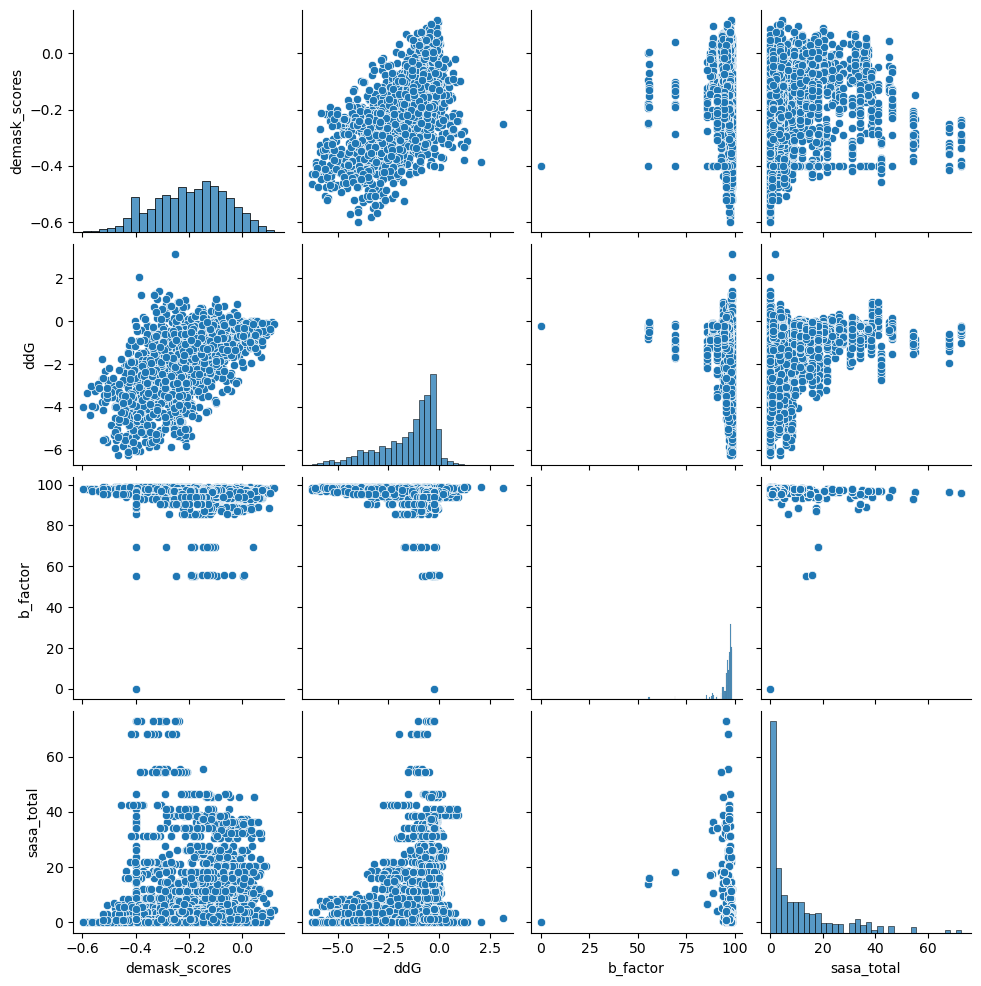

In [20]:
sns.pairplot(test_df[['demask_scores', 'ddG', 'b_factor', 'sasa_total']])

In [21]:
test_df['rank_pow'] = test_df.apply(lambda x: np.power(x['b_factor_rank'] * x['ddG_rank'] * x['demask_scores_rank'] * x['sasa_total_tank'], 1/4), axis=1)
# test_df['rank_pow'] = test_df.apply(lambda x: np.power(x['b_factor_rank'] * x['ddG_rank'] * x['demask_scores_rank'], 1/3), axis=1)
test_df.head()

,seq_id,protein_sequence,pH,data_source,n_edits,edit_type,edit_idx,old_aa,new_aa,b_factor,...,b_factor_adj,demask_scores,sasa_total,ddG_rank,demask_scores_rank,b_factor_rank,b_factor_adj_rank,sub_score_rank,sasa_total_tank,rank_pow
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,E,55.23,...,46.455659,-0.2504,13.86,2115.5,832.0,2408.0,2203.0,313.0,1752.0,1650.751631
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,16,L,K,55.23,...,43.708551,-0.2494,13.86,2190.5,836.5,2408.0,2212.0,704.5,1752.0,1667.438968
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,1,deletion,16,L,-,55.23,...,53.327592,-0.4000,13.86,2056.5,196.5,2408.0,2080.0,39.0,1752.0,1142.669047
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,C,69.25,...,58.248314,-0.1813,18.19,1032.0,1240.0,2386.5,1725.5,313.0,1923.5,1556.821257
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,17,K,F,69.25,...,54.803859,-0.1822,18.19,987.0,1234.0,2386.5,2053.5,704.5,1923.5,1537.699543


In [22]:
test_df.sort_values('rank_pow').head(10)

,seq_id,protein_sequence,pH,data_source,n_edits,edit_type,edit_idx,old_aa,new_aa,b_factor,...,b_factor_adj,demask_scores,sasa_total,ddG_rank,demask_scores_rank,b_factor_rank,b_factor_adj_rank,sub_score_rank,sasa_total_tank,rank_pow
543,31933,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,123,L,D,98.50,...,86.758512,-0.4655,0.0,1.0,47.0,137.0,86.0,122.5,234.0,35.035520
909,32299,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,175,Y,P,98.61,...,82.943918,-0.5159,0.0,32.0,18.0,38.5,149.5,313.0,234.0,47.728168
1070,32460,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,206,Y,P,98.58,...,82.918684,-0.5223,0.0,28.0,14.0,73.5,156.0,313.0,234.0,50.956233
1751,33141,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,123,L,P,98.50,...,77.952060,-0.4274,0.0,3.0,97.5,137.0,481.5,704.5,234.0,55.336995
158,31548,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,47,W,E,98.62,...,82.952329,-0.4775,0.0,103.0,36.0,18.5,147.5,313.0,234.0,63.296811
537,31927,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,122,I,D,98.62,...,86.864208,-0.3250,0.0,12.0,456.5,18.5,81.5,122.5,234.0,69.783445
544,31934,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,123,L,E,98.50,...,82.851393,-0.4335,0.0,9.0,85.0,137.0,162.0,313.0,234.0,70.371930
1760,33150,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,122,I,P,98.62,...,78.047027,-0.3450,0.0,17.0,389.0,18.5,456.5,704.5,234.0,73.147001
553,31943,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,126,V,D,98.19,...,82.590643,-0.4279,0.0,4.0,92.5,339.5,183.0,313.0,234.0,73.631617
905,32295,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,1,substitution,175,Y,E,98.61,...,78.039113,-0.4347,0.0,41.0,84.0,38.5,462.0,704.5,234.0,74.633693


In [24]:
assert not test_df[submit_col].isna().any()
submit_df = pd.DataFrame({
    'seq_id': test_df.seq_id.values,
    'tm': test_df[submit_col].values,
})
submit_df.tm = submit_df.tm.fillna(0)
submit_df.to_csv('submissions/plldt-ddg-demask-sasa_submission.csv', index=False)
submit_df.head()

,seq_id,tm
0,31390,1650.751631
1,31391,1667.438968
2,31392,1142.669047
3,31393,1556.821257
4,31394,1537.699543


- Introduce DeMask & SASA, DeMask is to predict substitution effects, SASA is to obtain the surface areas.